### Урок №5

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('Lection5/churn_data.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    tick_marks = np.arange(len(classes))
    
    font = {'size' : 10}
    plt.rc('font', **font)
    plt.figure(figsize=(5, 4))
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.show()
    return cm

In [12]:
def print_roc_auc(y_test, y_score):
    """Нарисуем roc auc кривую"""
    sns.set(font_scale=1.2)
    sns.set_color_codes("muted")

    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    # plt.savefig("ROC.png")
    plt.show()

def print_roc_auc_many(y_test_y_score:list):
    """Нарисуем roc auc кривую"""
    sns.set(font_scale=1.2)
    sns.set_color_codes("muted") 
    plt.figure(figsize=(5, 4))
    
    for y_test, y_score, label in y_test_y_score:
        fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label=label)
    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.savefig("ROC.png")
    plt.show()

In [9]:
def calc_TPR_FPR_TNR(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TPR, FPR, TNR

def calc_retain(cnf_matrix, retain_loose, retain_get):
    """Подсчёт выгоды от повторного привлечения клиента
    :param retain_loose: сколько тратится на повторное привлечение клиента
    :param retain_get: ожидаемая прибыль от повторного привлечения
    """
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    retain_sum = (FP + TP) * retain_loose
    income = TP * retain_get
    return income - retain_sum

In [10]:
sns.set(font_scale=1.2)
sns.set_color_codes('muted')
roc_auc_many = []
attempt_results = []

def attempt(attempt_name, model):
    df = pd.read_csv('Lection5/churn_data.csv')
    categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
    continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

    gender = Pipeline([
                    ('selector', FeatureSelector(column='Gender')),
                    ('ohe', OHEEncoder(key='Gender'))
                ])

    gender.fit(X_train)

    gender.transform(X_test)

    final_transformers = list()

    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
                    ('selector', FeatureSelector(column=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))
                ])
        final_transformers.append((cat_col, cat_transformer))

    for cont_col in continuous_columns:
        cont_transformer = Pipeline([
                    ('selector', NumberSelector(key=cont_col)),
                    ('standard', StandardScaler())
                ])
        final_transformers.append((cont_col, cont_transformer))

    feats = FeatureUnion(final_transformers)

    feature_processing = Pipeline([('feats', feats)])

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', model(random_state = 42)),
    ])

    #обучим наш пайплайн
    pipeline.fit(X_train, y_train)

    #наши прогнозы для тестовой выборки
    y_score = pipeline.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_score)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    roc_auc_many.append([y_test, y_score, attempt_name])
    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    calc_TPR_FPR_TNR(cnf_matrix)

    return [attempt_name, 
             calc_retain(cnf_matrix, retain_loose=1, retain_get=2),
             *calc_TPR_FPR_TNR(cnf_matrix),
             thresholds[ix], 
             fscore[ix], 
             precision[ix], 
             recall[ix], 
             roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1]),
             log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:,1]) ]


attempt_results.append(attempt('LogReg', LogisticRegression))
attempt_results.append(attempt('XGB', XGBClassifier))

pd.DataFrame(attempt_results,
            columns=['',
                     'Retain', 
                     'TPR', 
                     'FPR', 
                     'TNR', 
                     'BestThreshold', 
                     'FScore', 
                     'Precision', 
                     'Recall', 
                     'roc auc score', 
                     'log loss score'])

,,Retain,TPR,FPR,TNR,BestThreshold,FScore,Precision,Recall,roc auc score,log loss score
0,LogReg,-48,0.565815,0.168759,0.831241,0.289522,0.50970,0.462400,0.567780,0.772077,0.426779
1,XGB,123,0.630648,0.099448,0.900552,0.373318,0.62585,0.619231,0.632613,0.860921,0.350692


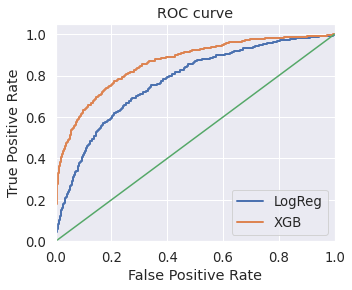

In [13]:
print_roc_auc_many(roc_auc_many)